In [1]:
%reload_ext autoreload
%autoreload 2

import sys

sys.path.append('../')

import pandas as pd
from generator_modules.load_dataset import load_ds

SEED: int = 42

PATH: str = '../data/transformed/'

START: str = '2024-06-11'
END: str = '2024-09-14'

print("Reading files...")
transactions_df: pd.DataFrame = load_ds(PATH, START, END)
print("Transactions read from files: ", len(transactions_df))
print("Fraudulent transactions: ", transactions_df.IS_FRAUD.sum())

Reading files...
Transactions read from files:  726864
Fraudulent transactions:  5106


In [2]:
columns_to_exclude: list = ['TRX_ID', 'CLIENT_ID', 'TERMINAL_ID', 'IS_FRAUD', 'FRAUD_SCENARIO', 'TRX_DATETIME', 'TRX_SECONDS', 'TRX_DAYS']

input_features: list = [col for col in transactions_df.columns if col not in columns_to_exclude]
output_features: str = 'IS_FRAUD'

In [3]:
import datetime

from classification_modules.normaliser import normalize_data

start_date_training: datetime = datetime.datetime.strptime("2024-07-25", "%Y-%m-%d")

from classification_modules.classificationClass import Classification

classificate: Classification = Classification()

In [4]:
import torch

if torch.cuda.is_available():
    device: str = "cuda" 
else:
    device = "cpu"
print("Selected device is",device)

Selected device is cuda


In [5]:
from deepLearning_modules.seeder import seed_everything

seed_everything(SEED)

In [6]:
import torch.utils
import torch.utils.data

criterion: torch.nn.BCELoss = torch.nn.BCELoss().to(device)

In [7]:
training_duration=7
delay_duration=7
test_duration=7

delta_valid = test_duration

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delay_duration+delta_valid))

(train_set, valid_set)=classificate.split_train_test(transactions_df,start_date_training_with_valid,
                                       training_duration=training_duration,delay_duration=delay_duration,test_duration=test_duration)

(train_set, valid_set)=normalize_data(train_set, valid_set, input_features)

In [8]:
import torch.optim.lr_scheduler as lr_scheduler

from deepLearning_modules.training_tools import prepare_data_loaders
from deepLearning_modules.training_tools import train_model_earlystopping_metrics

from deepLearning_modules.fcMLPClass import SimpleTransactionMLP

seed_everything(SEED)

model_name: str = 'best_fc.pth'

model = SimpleTransactionMLP(len(input_features)).to(device)

trainer, validator = prepare_data_loaders(train_df=train_set, valid_df=valid_set, input_features=input_features, output_feature=output_features, batch_size=64, device=device)

criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

results = train_model_earlystopping_metrics(model=model, trainer=trainer, validator=validator, optimizer=optimizer, criterion=criterion, patience=3, max_epochs=500, verbose=True, model_name=model_name, scheduler=scheduler)

trained_model = results['model']
training_time = results['training_time']
train_loss = results['train_losses']
valid_loss = results['valid_losses']

c:\Users\gc042\OneDrive\Desktop\Projects\datamining_proj\datamining_proj\venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/500: train loss: 0.4360781507960828
New best score: 0.2989424535129038
Model checkpoint saved at: ./models/best/best_fc.pth
Epoch 2/500: train loss: 0.09284006174380417
New best score: 0.02550678401563423
Model checkpoint saved at: ./models/best/best_fc.pth
Epoch 3/500: train loss: 0.022057553156505066
New best score: 0.020815740706694345
Model checkpoint saved at: ./models/best/best_fc.pth
Epoch 4/500: train loss: 0.021191247396551333
New best score: 0.020189503763102683
Model checkpoint saved at: ./models/best/best_fc.pth
Epoch 5/500: train loss: 0.02086526229909708
New best score: 0.019134462044448793
Model checkpoint saved at: ./models/best/best_fc.pth
Epoch 6/500: train loss: 0.020684188748959553
New best score: 0.018450974773156017
Model checkpoint saved at: ./models/best/best_fc.pth
Epoch 7/500: train loss: 0.02045098411336345
1 iterations since the best score.
Epoch 8/500: train loss: 0.02024687472776872
2 iterations since the best score.
Epoch 9/500: train loss: 0.0200

In [9]:
print(f"Final Validation Metrics:\n"
          f"Accuracy: {results['final_metrics']['accuracy']:.4f}\n"
          f"Precision: {results['final_metrics']['precision']:.4f}\n"
          f"Recall: {results['final_metrics']['recall']:.4f}\n"
          f"F1 Score: {results['final_metrics']['f1']:.4f}\n"
          f"AUC-ROC: {results['final_metrics']['auc_roc']:.4f}\n"
          f"Average Precision: {results['final_metrics']['average_precision']:.4f}\n"
          f"Top-K Accuracy: {results['final_metrics']['top_k_accuracy']:.4f}")

Final Validation Metrics:
Accuracy: 0.9967
Precision: 0.8161
Recall: 0.5726
F1 Score: 0.6730
AUC-ROC: 0.8536
Average Precision: 0.6336
Top-K Accuracy: 0.9800


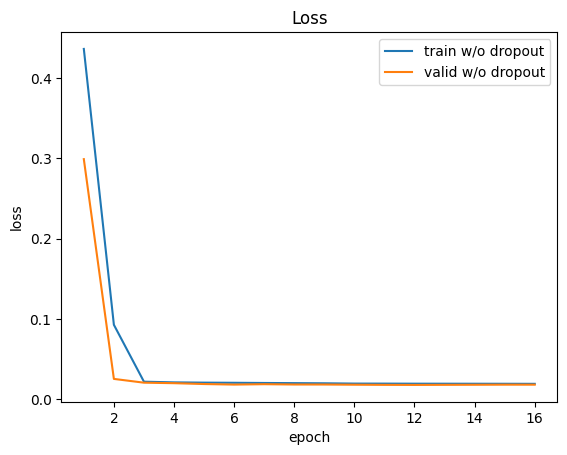

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_loss))+1, train_loss)
plt.plot(np.arange(len(valid_loss))+1, valid_loss)
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/o dropout','valid w/o dropout'])

In [11]:
from deepLearning_modules.fcMLPDropoutClass import SimpleTransactionMLPWithDropout

seed_everything(SEED)

model_name: str = 'best_fc_dropout.pth'

model = SimpleTransactionMLPWithDropout(len(input_features), 0.2).to(device)

trainer, validator = prepare_data_loaders(train_df=train_set, valid_df=valid_set, input_features=input_features, output_feature=output_features, batch_size=64, device=device)

criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

results = train_model_earlystopping_metrics(model=model, trainer=trainer, validator=validator, optimizer=optimizer, criterion=criterion, patience=3, max_epochs=500, verbose=True, model_name=model_name, scheduler=scheduler)

trained_model = results['model']
training_time = results['training_time']
train_loss_dropout = results['train_losses']
valid_loss_dropout = results['valid_losses']

c:\Users\gc042\OneDrive\Desktop\Projects\datamining_proj\datamining_proj\venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/500: train loss: 0.20620035946891344
New best score: 0.03335288706635442
Model checkpoint saved at: ./models/best/best_fc_dropout.pth
Epoch 2/500: train loss: 0.04008496622905409
New best score: 0.02793460252241083
Model checkpoint saved at: ./models/best/best_fc_dropout.pth
Epoch 3/500: train loss: 0.03492061861003079
New best score: 0.02375210610507252
Model checkpoint saved at: ./models/best/best_fc_dropout.pth
Epoch 4/500: train loss: 0.03181484859718863
New best score: 0.0226973621683967
Model checkpoint saved at: ./models/best/best_fc_dropout.pth
Epoch 5/500: train loss: 0.029937009253957057
New best score: 0.020609531489339993
Model checkpoint saved at: ./models/best/best_fc_dropout.pth
Epoch 6/500: train loss: 0.029407338166643576
New best score: 0.01952850655568655
Model checkpoint saved at: ./models/best/best_fc_dropout.pth
Epoch 7/500: train loss: 0.028821521130480705
New best score: 0.018799286115092226
Model checkpoint saved at: ./models/best/best_fc_dropout.pth
Ep

In [12]:
print(f"Final Validation Metrics:\n"
          f"Accuracy: {results['final_metrics']['accuracy']:.4f}\n"
          f"Precision: {results['final_metrics']['precision']:.4f}\n"
          f"Recall: {results['final_metrics']['recall']:.4f}\n"
          f"F1 Score: {results['final_metrics']['f1']:.4f}\n"
          f"AUC-ROC: {results['final_metrics']['auc_roc']:.4f}\n"
          f"Average Precision: {results['final_metrics']['average_precision']:.4f}\n"
          f"Top-K Accuracy: {results['final_metrics']['top_k_accuracy']:.4f}")

Final Validation Metrics:
Accuracy: 0.9969
Precision: 0.9641
Recall: 0.5054
F1 Score: 0.6631
AUC-ROC: 0.8525
Average Precision: 0.6347
Top-K Accuracy: 0.9700


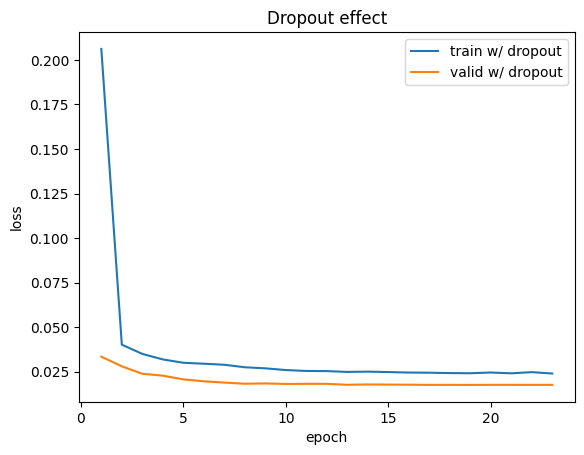

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_loss_dropout))+1, train_loss_dropout)
plt.plot(np.arange(len(valid_loss_dropout))+1, valid_loss_dropout)
plt.title("Dropout effect")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/ dropout','valid w/ dropout'])